# Data Preprocessing

In [1]:
# In[1] ─ Imports & Setup  (unchanged)
import os, urllib.parse, pandas as pd, numpy as np
from dotenv import load_dotenv
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)

# In[2] ─ Load environment and connect to MySQL  (unchanged)
load_dotenv()
user   = os.getenv("MYSQL_USER")
pw     = urllib.parse.quote_plus(os.getenv("MYSQL_PASSWORD"))
host   = os.getenv("MYSQL_HOST")
port   = os.getenv("MYSQL_PORT")
db     = os.getenv("MYSQL_DATABASE")
engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

# -------------------------------------------------------------------
# 1) Load raw tables (unchanged)
ohlcv = pd.read_sql_query(
    "SELECT datetime, open, high, low, close, volume "
    "FROM ohlcv WHERE timeframe='1h'",
    engine, parse_dates=['datetime'], index_col='datetime'
)
ta = pd.read_sql_table(
    'ta_features_1h', engine,
    index_col='datetime', parse_dates=['datetime']
)

# 2) Drop bad TA columns and align start (unchanged)
ta = ta.drop(columns=['TEMA_real', 'TRIX_real'], errors='ignore')
first_valid_dates = [ta[col].first_valid_index() for col in ta.columns]
start_date = max(d for d in first_valid_dates if d is not None)
ta    = ta.loc[start_date:]
ohlcv = ohlcv.loc[start_date:]

# 3) Impute OHLCV & TA fully (unchanged)
ohlcv_ffb = ohlcv.ffill().bfill()
ta_ffb    = ta.ffill().bfill()

# -------------------------------------------------------------------
# 4) **NEW** ─ Build regression target and classification label FIRST
ret1  = ohlcv_ffb['close'].pct_change().rename('ret1')

dir_  = pd.Series(
    np.where(ret1 >= 0, 1, 0),
    index=ret1.index,
    name='dir'
)

# 5) **MODIFIED** ─ Merge everything in ONE concat (prevents fragmentation)
price_cols = ['open', 'high', 'low', 'close', 'volume']
df_all = pd.concat(
    [
        ohlcv_ffb,
        ta_ffb.drop(columns=price_cols),
        ret1,
        dir_                                  # ← classification column
    ],
    axis=1,
    join='inner'
)

# 6) **MODIFIED location** ─ Drop rows where ret1 is NaN (first row)
df_all = df_all.dropna(subset=['ret1'])

# 7) Drop constant columns (run once)
const_cols = [c for c in df_all.columns if df_all[c].nunique() <= 1]
df_all = df_all.drop(columns=const_cols)

# 8) Ensure column names are strings (unchanged)
df_all.columns = df_all.columns.map(str)

# 9) Optional: de‑fragment explicitly (harmless copy)
df_all = df_all.copy()

# -------------------------------------------------------------------
# 10) Quick sanity‑check: class distribution
print("Class distribution:\n", df_all['dir'].value_counts())
df_all.head()


Class distribution:
 dir
1    16812
0    16393
Name: count, dtype: int64


,open,high,low,close,volume,HT_DCPERIOD_real,HT_DCPHASE_real,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE_integer,ADD_real,DIV_real,MAX_real,MAXINDEX_integer,MIN_real,MININDEX_integer,MINMAX_min,MINMAX_max,MINMAXINDEX_minidx,MINMAXINDEX_maxidx,MULT_real,SUB_real,SUM_real,ATAN_real,CEIL_real,COS_real,FLOOR_real,LN_real,LOG10_real,SIN_real,SQRT_real,TAN_real,ADX_real,ADXR_real,APO_real,AROON_aroondown,AROON_aroonup,AROONOSC_real,BOP_real,CCI_real,CMO_real,DX_real,MACD_macd,MACD_macdsignal,MACD_macdhist,MACDEXT_macd,MACDEXT_macdsignal,MACDEXT_macdhist,MACDFIX_macd,MACDFIX_macdsignal,MACDFIX_macdhist,MFI_real,MINUS_DI_real,MINUS_DM_real,MOM_real,PLUS_DI_real,PLUS_DM_real,PPO_real,ROC_real,ROCP_real,ROCR_real,ROCR100_real,RSI_real,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,ULTOSC_real,WILLR_real,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA_real,EMA_real,HT_TRENDLINE_real,KAMA_real,MA_real,MAMA_mama,MAMA_fama,MIDPOINT_real,MIDPRICE_real,SAR_real,SAREXT_real,SMA_real,T3_real,TRIMA_real,WMA_real,CDL3WHITESOLDIERS_integer,CDLADVANCEBLOCK_integer,CDLBELTHOLD_integer,CDLCLOSINGMARUBOZU_integer,CDLDOJI_integer,CDLDRAGONFLYDOJI_integer,CDLENGULFING_integer,CDLGRAVESTONEDOJI_integer,CDLHAMMER_integer,CDLHANGINGMAN_integer,CDLHARAMI_integer,CDLHARAMICROSS_integer,CDLHIGHWAVE_integer,CDLHIKKAKE_integer,CDLHIKKAKEMOD_integer,CDLIDENTICAL3CROWS_integer,CDLLONGLEGGEDDOJI_integer,CDLLONGLINE_integer,CDLMARUBOZU_integer,CDLMATCHINGLOW_integer,CDLRICKSHAWMAN_integer,CDLSEPARATINGLINES_integer,CDLSHORTLINE_integer,CDLSPINNINGTOP_integer,CDLSTALLEDPATTERN_integer,CDLTAKURI_integer,AVGPRICE_real,MEDPRICE_real,TYPPRICE_real,WCLPRICE_real,BETA_real,CORREL_real,LINEARREG_real,LINEARREG_ANGLE_real,LINEARREG_INTERCEPT_real,LINEARREG_SLOPE_real,STDDEV_real,TSF_real,VAR_real,ATR_real,NATR_real,TRANGE_real,AD_real,ADOSC_real,OBV_real,ret1,dir
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-08 04:00:00,33320.02,33354.00,33181.00,33300.76,0.398287,27.353440,312.950019,-858.674980,-1003.307868,-0.731948,-0.035771,1.0,66535.00,1.005214,34852.5,48.0,33251.46,60.0,33251.46,34852.5,60.0,48.0,1.106719e+09,173.00,1030015.18,1.570766,33301.0,0.992552,33300.0,10.413335,4.522454,-0.121825,182.484958,-0.122739,28.640298,23.890103,-403.519808,92.857143,0.000000,-92.857143,-0.111329,-98.078973,-44.587524,56.114196,-283.777197,-126.803072,-156.974125,-403.519808,-102.594815,-300.924993,-268.068535,-118.582280,-149.486255,25.733512,36.256245,1439.035065,-1379.31,10.192119,404.532147,-1.174703,-3.977241,-0.039772,0.960228,96.022759,27.706238,22.129392,17.480813,25.963958,22.129392,74.994433,4.563730e+01,39.811681,-87.293305,33400.625839,33318.512,33236.398161,33959.904316,34105.219388,34393.058843,34053.621264,34333.839333,33662.268669,34152.471168,33965.765,33939.695,33920.398439,-33920.398439,34333.839333,33357.828236,34531.668083,34163.920065,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,-100.0,0.0,0.0,33288.9450,33267.500,33278.586667,33284.1300,0.126478,0.972974,33182.253714,-89.562749,34885.694857,-131.033934,41.056920,33051.219780,1685.670655,284.051841,0.852989,173.00,-1.136618,-0.160647,-3.859353,-0.000578,0
2021-07-08 05:00:00,33300.76,33344.94,33124.37,33154.83,0.483069,27.427016,-43.303406,-1313.839928,-496.092382,-0.685862,0.029607,1.0,66469.31,1.006659,34852.5,48.0,33154.83,65.0,33154.83,34852.5,65.0,48.0,1.104530e+09,220.57,1028945.56,1.570766,33155.0,0.031925,33154.0,10.408944,4.520547,-0.999490,182.084678,-31.307531,30.703096,24.406991,-477.621795,85.714286,21.428571,-64.285714,-0.661604,-90.679108,-48.865931,57.519474,-313.462145,-164.134887,-149.327258,-477.621795,-175.132429,-302.489366,-296.579597,-154.181743,-142.397854,23.937476,35.658713,1392.876846,-1473.97,9.616594,375.636994,-1.392428,-4.256486,-0.042565,0.957

<Axes: title={'center': 'BTCUSDT Price Direction Data'}, xlabel='datetime'>

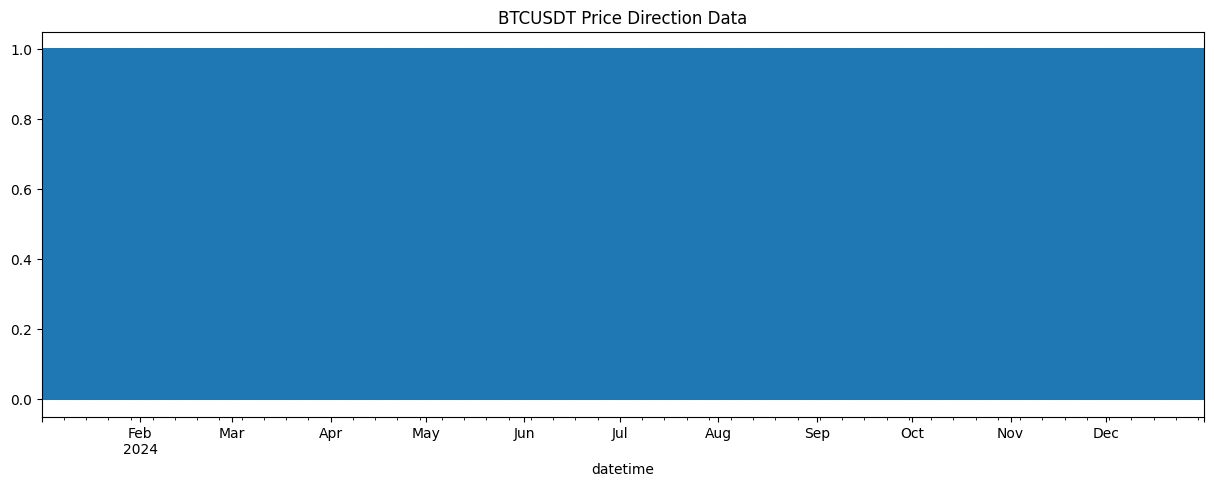

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
df_all['dir'].loc[(df_all.index > '2024-01-01') & (df_all.index < '2025-01-01')].plot(ax=ax,title='BTCUSDT Price Direction Data')

# Feature Engineering and Selection

In [3]:
import pandas as pd, numpy as np
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif

# ── CONFIG ─────────────────────────────────────────────────────────────
TARGET      = 'dir'
MAX_LAG     = 14
N_SPLITS    = 5
KEEP_PCT    = 0.30
HEAVY_PREF  = ('volume','ATR','OBV')

# 1) Prepare X_final, y (mutual-info lag selection) ─────────────────────
y  = df_all[TARGET]
X0 = df_all.drop(columns=[TARGET])

# build lags 1…MAX_LAG
frames = [X0.shift(L).add_suffix(f'_lag{L}') for L in range(1, MAX_LAG+1)]
X_lag = pd.concat(frames, axis=1).dropna()
y     = y.loc[X_lag.index]

# X_red = X_lag.copy()

# robust-scale heavy tails
heavy = [c for c in X_lag.columns if c.startswith(HEAVY_PREF)]
ct = ColumnTransformer([
    ('robust', RobustScaler(), heavy),
    ('keep',   'passthrough', [c for c in X_lag.columns if c not in heavy])
])

# avg MI over folds
mi = pd.Series(0.0, index=X_lag.columns)
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
for tr, _ in tscv.split(X_lag):
    Xtr = ct.fit_transform(X_lag.iloc[tr])
    ytr = y.iloc[tr]
    mi  += mutual_info_classif(Xtr, ytr, discrete_features=False)
mi /= N_SPLITS

# keep top KEEP_PCT of lags
k        = int(len(mi) * KEEP_PCT)
top_feats= mi.nlargest(k).index
X_red    = X_lag[top_feats]
X_red

,MINMAXINDEX_maxidx_lag2,MULT_real_lag2,MFI_real_lag1,MINMAXINDEX_minidx_lag9,ROCR100_real_lag1,MINUS_DM_real_lag10,ADXR_real_lag4,LOG10_real_lag1,WMA_real_lag10,TYPPRICE_real_lag1,HT_SINE_leadsine_lag13,STDDEV_real_lag3,CDLLONGLEGGEDDOJI_integer_lag4,TYPPRICE_real_lag14,CDL3WHITESOLDIERS_integer_lag13,CDLLONGLEGGEDDOJI_integer_lag1,low_lag1,ATAN_real_lag3,COS_real_lag3,MINMAXINDEX_maxidx_lag6,MACDFIX_macdsignal_lag2,MINMAX_max_lag6,SUB_real_lag2,CMO_real_lag5,BBANDS_middleband_lag13,ATR_real_lag11,MAXINDEX_integer_lag3,CDLHIKKAKE_integer_lag2,CORREL_real_lag1,ADXR_real_lag6,STOCHF_fastd_lag1,ROCR100_real_lag13,STOCHF_fastk_lag4,AD_real_lag10,WILLR_real_lag2,FLOOR_real_lag5,ATAN_real_lag5,ADX_real_lag6,MIN_real_lag10,EMA_real_lag13,HT_PHASOR_quadrature_lag9,HT_PHASOR_inphase_lag2,CDLHARAMI_integer_lag13,MINMAX_max_lag7,FLOOR_real_lag1,PLUS_DI_real_lag13,WMA_real_lag7,MAMA_fama_lag4,volume_lag1,ADX_real_lag3,MACDEXT_macdsignal_lag12,MININDEX_integer_lag5,BBANDS_lowerband_lag1,MAMA_mama_lag1,EMA_real_lag8,ATAN_real_lag6,CDLHIGHWAVE_integer_lag11,WMA_real_lag13,AVGPRICE_real_lag12,ROC_real_lag13,CMO_real_lag4,EMA_real_lag12,STOCH_slowd_lag12,SUM_real_lag2,ROCP_real_lag11,MAMA_mama_lag4,STOCH_slowk_lag11,HT_TRENDLINE_real_lag11,MEDPRICE_real_lag12,MACDEXT_macd_lag13,ROCR_real_lag11,STOCHRSI_fastk_lag13,MEDPRICE_real_lag13,STOCH_slowk_lag9,SAREXT_real_lag4,CDLHARAMICROSS_integer_lag4,CDLSEPARATINGLINES_integer_lag8,ADOSC_real_lag9,MIN_real_lag6,CDLLONGLINE_integer_lag1,CDLGRAVESTONEDOJI_integer_lag4,DEMA_real_lag1,MACDFIX_macdhist_lag14,AVGPRICE_real_lag13,CDLCLOSINGMARUBOZU_integer_lag1,ATR_real_lag10,MAMA_fama_lag11,MACD_macdhist_lag2,ULTOSC_real_lag7,CDLSEPARATINGLINES_integer_lag6,SMA_real_lag4,MINMAX_max_lag8,SAREXT_real_lag8,MULT_real_lag1,MINMAX_min_lag6,CDL3WHITESOLDIERS_integer_lag2,MEDPRICE_real_lag9,CDLSEPARATINGLINES_integer_lag12,MACD_macdsignal_lag3,LINEARREG_INTERCEPT_real_lag9,CDLHIKKAKEMOD_integer_lag1,MIDPOINT_real_lag1,KAMA_real_lag2,MAMA_fama_lag5,CDLRICKSHAWMAN_integer_lag7,VAR_real_lag5,MIN_real_lag12,TYPPRICE_real_lag13,CDLHARAMI_integer_lag12,MACD_macd_lag1,WCLPRICE_real_lag4,MINMAX_min_lag7,HT_TRENDMODE_integer_lag13,ADX_real_lag4,MININDEX_integer_lag9,CDLSEPARATINGLINES_integer_lag9,STOCHF_fastk_lag11,DIV_real_lag11,MININDEX_integer_lag2,HT_SINE_leadsine_lag11,CDLMATCHINGLOW_integer_lag1,T3_real_lag4,WILLR_real_lag12,MACDFIX_macd_lag12,MIN_real_lag7,OBV_real_lag13,STOCHF_fastd_lag9,CDLSTALLEDPATTERN_integer_lag5,HT_PHASOR_inphase_lag8,STOCHF_fastk_lag1,SUB_real_lag10,HT_SINE_sine_lag2,ADOSC_real_lag1,HT_SINE_sine_lag11,CDLDOJI_integer_lag9,STOCHRSI_fastk_lag10,high_lag6,STDDEV_real_lag13,CDLRICKSHAWMAN_integer_lag9,PPO_real_lag13,VAR_real_lag8,ATR_real_lag2,WMA_real_lag2,HT_SINE_sine_lag5,FLOOR_real_lag7,CDLENGULFING_integer_lag1,CDLLONGLINE_integer_lag7,TRIMA_real_lag2,OBV_real_lag8,FLOOR_real_lag4,PLUS_DI_real_lag7,STOCHF_fastk_lag9,ROCR_real_lag10,PPO_real_lag6,RSI_real_lag13,AVGPRICE_real_lag1,AD_real_lag8,PPO_real_lag10,CEIL_real_lag6,HT_PHASOR_inphase_lag6,MFI_real_lag11,BBANDS_lowerband_lag11,KAMA_real_lag3,BBANDS_upperband_lag4,ret1_lag7,LN_real_lag14,CORREL_real_lag12,AVGPRICE_real_lag8,ADOSC_real_lag6,AD_real_lag1,LINEARREG_real_lag12,CMO_real_lag12,WMA_real_lag9,MINUS_DI_real_lag13,RSI_real_lag5,TRANGE_real_lag1,MIN_real_lag13,MACDEXT_macdsignal_lag11,low_lag14,ROCR_real_lag13,STOCH_slowd_lag14,MACD_macd_lag14,CDLHARAMICROSS_integer_lag9,VAR_real_lag13,WILLR_real_lag1,CDLRICKSHAWMAN_integer_lag8,MININDEX_integer_lag7,ret1_lag10,CDLHARAMICROSS_integer_lag10,BBANDS_lowerband_lag7,volume_lag6,ROC_real_lag10,SAREXT_real_lag7,MIDPOINT_real_lag7,SAR_real_lag7,volume_lag2,MIDPRICE_real_lag7,CDLCLOSINGMARUBOZU_integer_lag7,CDLLONGLINE_integer_lag2,FLOOR_real_lag2,STOCH_slowd_lag1,CDLBELTHOLD_integer_lag8,LOG10_real_lag2,HT_PHASOR_inphase_lag11,WILLR_real_lag7,AD_real_lag6,MACDEXT_macd_lag8,AROONOSC_real_lag14,MINMAXINDEX_minidx_lag10,CDLSPINNINGTOP_integer_lag14,CDLCLOSINGMARUBOZU_integer_lag2,high_lag3

In [4]:
# X is your DataFrame of selected features
corr = X_red.corr(method='spearman').abs()

# Build an “upper triangle” mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find columns to drop: any that have corr > thresh with an earlier col
to_drop = [col for col in upper.columns if any(upper[col] > 0.8)]

X_reduced = X_red.drop(columns=to_drop)
X_reduced

,MINMAXINDEX_maxidx_lag2,MULT_real_lag2,MFI_real_lag1,ROCR100_real_lag1,MINUS_DM_real_lag10,ADXR_real_lag4,HT_SINE_leadsine_lag13,STDDEV_real_lag3,CDLLONGLEGGEDDOJI_integer_lag4,CDL3WHITESOLDIERS_integer_lag13,CDLLONGLEGGEDDOJI_integer_lag1,COS_real_lag3,MACDFIX_macdsignal_lag2,SUB_real_lag2,CMO_real_lag5,CDLHIKKAKE_integer_lag2,CORREL_real_lag1,STOCHF_fastd_lag1,ROCR100_real_lag13,STOCHF_fastk_lag4,WILLR_real_lag2,HT_PHASOR_quadrature_lag9,HT_PHASOR_inphase_lag2,CDLHARAMI_integer_lag13,PLUS_DI_real_lag13,volume_lag1,MACDEXT_macdsignal_lag12,CDLHIGHWAVE_integer_lag11,STOCH_slowd_lag12,ROCP_real_lag11,STOCH_slowk_lag11,STOCHRSI_fastk_lag13,STOCH_slowk_lag9,SAREXT_real_lag4,CDLHARAMICROSS_integer_lag4,CDLSEPARATINGLINES_integer_lag8,ADOSC_real_lag9,CDLLONGLINE_integer_lag1,CDLGRAVESTONEDOJI_integer_lag4,MACDFIX_macdhist_lag14,CDLCLOSINGMARUBOZU_integer_lag1,MACD_macdhist_lag2,ULTOSC_real_lag7,CDLSEPARATINGLINES_integer_lag6,SAREXT_real_lag8,CDL3WHITESOLDIERS_integer_lag2,CDLSEPARATINGLINES_integer_lag12,CDLHIKKAKEMOD_integer_lag1,CDLRICKSHAWMAN_integer_lag7,VAR_real_lag5,CDLHARAMI_integer_lag12,HT_TRENDMODE_integer_lag13,CDLSEPARATINGLINES_integer_lag9,STOCHF_fastk_lag11,DIV_real_lag11,CDLMATCHINGLOW_integer_lag1,WILLR_real_lag12,OBV_real_lag13,CDLSTALLEDPATTERN_integer_lag5,STOCHF_fastk_lag1,HT_SINE_sine_lag2,ADOSC_real_lag1,HT_SINE_sine_lag11,CDLDOJI_integer_lag9,STOCHRSI_fastk_lag10,STDDEV_real_lag13,HT_SINE_sine_lag5,CDLENGULFING_integer_lag1,CDLLONGLINE_integer_lag7,PLUS_DI_real_lag7,STOCHF_fastk_lag9,MFI_real_lag11,ret1_lag7,CORREL_real_lag12,ADOSC_real_lag6,TRANGE_real_lag1,STOCH_slowd_lag14,CDLHARAMICROSS_integer_lag9,CDLRICKSHAWMAN_integer_lag8,ret1_lag10,CDLHARAMICROSS_integer_lag10,CDLCLOSINGMARUBOZU_integer_lag7,CDLLONGLINE_integer_lag2,CDLBELTHOLD_integer_lag8,WILLR_real_lag7,AROONOSC_real_lag14,CDLSPINNINGTOP_integer_lag14,CDLCLOSINGMARUBOZU_integer_lag2,NATR_real_lag13,CDLCLOSINGMARUBOZU_integer_lag8,CDLCLOSINGMARUBOZU_integer_lag4,CDLADVANCEBLOCK_integer_lag4,CDLBELTHOLD_integer_lag4,ULTOSC_real_lag1,CDLMARUBOZU_integer_lag12,ret1_lag8,TAN_real_lag2,CDLDRAGONFLYDOJI_integer_lag14,CDLLONGLEGGEDDOJI_integer_lag2,DIV_real_lag14,SIN_real_lag2,MACD_macdhist_lag11,SAREXT_real_lag1,ULTOSC_real_lag14,STOCHRSI_fastk_lag3,CDLDRAGONFLYDOJI_integer_lag2,CDLHANGINGMAN_integer_lag7,DX_real_lag4,CDLHIKKAKE_integer_lag4,ret1_lag1,COS_real_lag2,STOCHRSI_fastk_lag12,ULTOSC_real_lag12,MACDEXT_macdhist_lag1,MFI_real_lag5,CDLMARUBOZU_integer_lag5,CDLTAKURI_integer_lag5,MACDFIX_macdhist_lag6,ULTOSC_real_lag10,SIN_real_lag7,CDLHANGINGMAN_integer_lag6,CDLHIGHWAVE_integer_lag14,STOCHRSI_fastd_lag3,CDLHIKKAKEMOD_integer_lag9,STOCHRSI_fastd_lag5,CDLRICKSHAWMAN_integer_lag11,HT_SINE_leadsine_lag1,SIN_real_lag5,BETA_real_lag11,ret1_lag4,HT_DCPHASE_real_lag4,CDLRICKSHAWMAN_integer_lag10,CDLMARUBOZU_integer_lag10,CDL3WHITESOLDIERS_integer_lag9,AROONOSC_real_lag1,HT_PHASOR_quadrature_lag1,CDLHANGINGMAN_integer_lag14,AROON_aroonup_lag4,CDLBELTHOLD_integer_lag1,ROC_real_lag4,AROONOSC_real_lag5,CDLLONGLINE_integer_lag11,CDLHARAMI_integer_lag10,AROON_aroonup_lag10,CDLCLOSINGMARUBOZU_integer_lag10,BETA_real_lag1,CDLSEPARATINGLINES_integer_lag1,HT_PHASOR_quadrature_lag3,HT_TRENDMODE_integer_lag2,ret1_lag5,SIN_real_lag12,CDLLONGLINE_integer_lag12,AROON_aroondown_lag2,HT_DCPERIOD_real_lag14,CDLGRAVESTONEDOJI_integer_lag1,SIN_real_lag3,CDLIDENTICAL3CROWS_integer_lag1,CDLMARUBOZU_integer_lag1,CDLSHORTLINE_integer_lag14,DX_real_lag12,CDLSTALLEDPATTERN_integer_lag8,CDLIDENTICAL3CROWS_integer_lag11,CDLSEPARATINGLINES_integer_lag2,CDLENGULFING_integer_lag6,CDLHAMMER_integer_lag13,MACDEXT_macdhist_lag12,CDLDRAGONFLYDOJI_integer_lag9,CDLLONGLINE_integer_lag10,HT_SINE_sine_lag9,CDLMATCHINGLOW_integer_lag12,STOCHF_fastk_lag8,CDLHARAMICROSS_integer_lag14,CDLHAMMER_integer_lag4,CDLSHORTLINE_integer_lag11,HT_DCPHASE_real_lag10,CDLHARAMI_integer_lag5,HT_TRENDMODE_integer_lag1,CDLTAKURI_integer_lag10,HT_PHASOR_quadrature_lag2,CDLTAKURI_integer_lag8,HT_SINE_leadsine_l

## Feature Selection Method 1: Boruta

In [116]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- 1) Set up a RandomForest with enough trees ----------------------------
rf = RandomForestClassifier(
    n_estimators=100,        # BorutaPy will actually override this with 'auto'
    max_depth=5,
    n_jobs=-1,
    random_state=42
)

# --- 2) Wrap in BorutaPy ---------------------------------------------------
boruta = BorutaPy(
    estimator=rf,
    n_estimators=100,        # let Boruta pick a sufficient forest size
    verbose=False,              # shows you progress of the shadow‐feature tests
    random_state=42,
)

# --- 3) Fit on your training data ------------------------------------------
# Pass the raw values; BorutaPy does its own internal shadow‐feature testing
boruta.fit(X_reduced.values, y.values)

# --- 4) Extract and rank all features by Boruta rank ------------------------
# boruta.ranking_: array of ints, 1 = confirmed important, ↑ = less important
ranks = pd.Series(boruta.ranking_, index=X_reduced.columns)

# Sort ascending (1 = best), then take the top 10 names
boruta_selected_mc = ranks.sort_values().head(10).index.tolist()
X_boruta = X_reduced[boruta_selected_mc].copy() 

print("Top 10 features by Boruta rank:")
for i, feat in enumerate(boruta_selected_mc, 1):
    print(f"{i:2d}. {feat} (rank={ranks[feat]})")


Top 10 features by Boruta rank:
 1. STOCHF_fastk_lag1 (rank=1)
 2. WILLR_real_lag2 (rank=1)
 3. ADOSC_real_lag1 (rank=1)
 4. STOCHRSI_fastd_lag3 (rank=1)
 5. ret1_lag1 (rank=1)
 6. ULTOSC_real_lag1 (rank=1)
 7. ROCR100_real_lag1 (rank=1)
 8. STOCHF_fastd_lag1 (rank=1)
 9. STOCHF_fastk_lag5 (rank=2)
10. ADOSC_real_lag12 (rank=2)


## Feature Selection Method 2: Genetic Algorithm

In [117]:
# ## In[3]: Genetic Algorithm (wrapper) for multiclass
# from sklearn.ensemble import RandomForestClassifier
# from genetic_selection import GeneticSelectionCV

# estimator_mc = RandomForestClassifier(n_jobs=-1, random_state=42)
# selector_mc = GeneticSelectionCV(
#     estimator=estimator_mc,
#     cv=5,
#     scoring='accuracy',
#     n_population=50,
#     crossover_proba=0.5,
#     mutation_proba=0.2,
#     n_generations=40,
#     n_jobs=-1,
#     max_features=50,
#     verbose=10
# )
# selector_mc.fit(X_red.values, y.values)
# ga_selected_mc = list(X_red.columns[selector_mc.support_])
# print("GA selected (multiclass):", ga_selected_mc)
# X_ga = X_red[ga_selected_mc].copy()

## Feature Selection Method 3: LightGMB

In [118]:
# ## In[4]: LightGBM embedded for multiclass
# import lightgbm as lgb

# lgbm_mc = lgb.LGBMClassifier(
#     objective='multiclass',
#     num_class=3,
#     random_state=42
# )
# lgbm_mc.fit(X_red, y)
# importances_mc = pd.Series(
#     lgbm_mc.feature_importances_, index=X_red.columns
# )
# lgbm_selected_mc = list(importances_mc.nlargest(10).index)
# print("LightGBM top 15 (multiclass):", lgbm_selected_mc)

# # 2) Use only selected features for tuning
# X_lgbm = X_red[lgbm_selected_mc].copy()

# Machine Learning 

In [141]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pandas as pd

# 1) Prepare X and y
X = X_boruta.copy()   
y = y.copy()

split_idx = int(0.8*len(X))
X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_val = X.iloc[split_idx+1:]
y_val = y.iloc[split_idx+1:]

clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    # use_label_encoder=False,
    random_state=42,
    n_jobs=-1,

    # Complexity control
    n_estimators=10000,          # start big, prune with ES
    early_stopping_rounds=50,   # stop if no val-loss improvement for 50 rounds
    max_depth=5,                # shallow trees generalize better
    learning_rate=0.001,         # smaller step size → smoother fit
    subsample=0.8,              # row sampling
    colsample_bytree=0.8,       # feature sampling

    # Split regularization
    gamma=1.0,                  # min loss reduction to make a split
    min_child_weight=5,         # min sum hessian in a leaf

    # Weight regularization
    reg_alpha=1.,              # L1
    reg_lambda=1.5,             # L2
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100,
)

[0]	validation_0-logloss:0.69304	validation_1-logloss:0.69309


[100]	validation_0-logloss:0.69122	validation_1-logloss:0.69225
[200]	validation_0-logloss:0.68961	validation_1-logloss:0.69157
[300]	validation_0-logloss:0.68815	validation_1-logloss:0.69102
[400]	validation_0-logloss:0.68685	validation_1-logloss:0.69058
[500]	validation_0-logloss:0.68568	validation_1-logloss:0.69019
[600]	validation_0-logloss:0.68460	validation_1-logloss:0.68989
[700]	validation_0-logloss:0.68362	validation_1-logloss:0.68968
[800]	validation_0-logloss:0.68271	validation_1-logloss:0.68952
[900]	validation_0-logloss:0.68187	validation_1-logloss:0.68940
[1000]	validation_0-logloss:0.68108	validation_1-logloss:0.68933
[1100]	validation_0-logloss:0.68032	validation_1-logloss:0.68930
[1200]	validation_0-logloss:0.67959	validation_1-logloss:0.68926
[1272]	validation_0-logloss:0.67911	validation_1-logloss:0.68926


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              random_state=42, ...)

<Axes: >

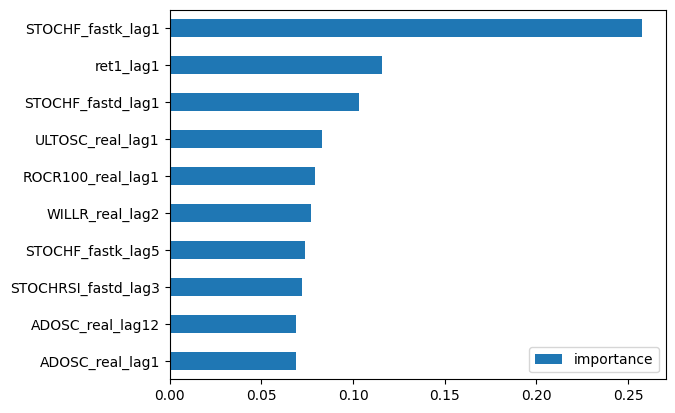

In [142]:
fi = pd.DataFrame(data = clf.feature_importances_,
                  index = clf.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind='barh')

In [143]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Predict labels on the validation set
y_pred = clf.predict(X_val)

# 2) Compute accuracy
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

# 3) (Optional) More diagnostics
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Validation accuracy: 0.5337

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.46      0.49      3285
           1       0.53      0.61      0.57      3353

    accuracy                           0.53      6638
   macro avg       0.53      0.53      0.53      6638
weighted avg       0.53      0.53      0.53      6638


Confusion Matrix:
[[1505 1780]
 [1315 2038]]


In [144]:
# 1) Predict labels on the validation set
y_proba = clf.predict_proba(X_val)
y_proba = y_proba.max(axis=1)

# 1) Predict labels on the validation set
y_pred = clf.predict(X_val)
y_pred = y_pred[y_proba>0.55]
y_test = y_val[y_proba>0.55]

# 2) Compute accuracy
val_accuracy = accuracy_score(y_test, y_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

# 3) (Optional) More diagnostics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Validation accuracy: 0.5827

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.41      0.48       835
           1       0.58      0.74      0.65       931

    accuracy                           0.58      1766
   macro avg       0.58      0.57      0.57      1766
weighted avg       0.58      0.58      0.57      1766


Confusion Matrix:
[[342 493]
 [244 687]]


In [145]:
print(f"percentage of trade occured per 1h data: {len(y_test)/len(y_val)*100:.3}%")

percentage of trade occured per 1h data: 26.6%
